In [1]:
import scimap as sm
import pandas as pd
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Running SCIMAP  2.3.5


c:\Users\vinicius.motta\.conda\envs\scimap\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



# Hypothetical Project

- The user has a single-cell `.csv` file from three patients.
- The goal is to perform dimensionality reduction (UMAP) and clustering (Phenograph), which I believe are already implemented in Tercen.
- The **new analysis** involves using the spatial coordinates (X, Y) from the single-cell data to perform neighborhood analysis.
- The output file should include columns for UMAP, Phenograph, and Cell Neighborhood results, appended to the original single-cell `.csv` file.


More information about the SCIMAP package and single-cell neighborhood analysis can be found at the following link:  
🔗 [https://scimap.xyz/](https://scimap.xyz/)

In [2]:
# Read single-cell csv file
patient1 = pd.read_csv("Patient1.csv")
patient2 = pd.read_csv("Patient2.csv")
patient3 = pd.read_csv("Patient3.csv")

# Add the imageid column required for neighbourhood analysis
patient1["imageid"]="Patient1"
patient2["imageid"]="Patient2"
patient3["imageid"]="Patient3"

# Concatenate files to process the entire dataset
df = pd.concat([patient1, patient2, patient3])

# Drop unnecessary columns for analysis
df.drop(["80ArAr",'131Xe', '134Xe',
       '136Ba', '138La','DNA1', 'DNA2', '196Pt', '206Pb',"Histone_126((2979))In113"], axis=1, inplace=True)

# Rename columns for easier reading
new_column_names = [x.split("(")[0] for x in df.columns[1:38]]
df.rename(columns = dict(zip(df.columns[1:38],new_column_names)), inplace=True)

# Rename `centroid-0` and `centroid-1` to `X_centroid` and `Y_centroid` to match neighborhood clustering parameters
df.rename(columns={"centroid-0":"Y_centroid", "centroid-1":"X_centroid"}, inplace=True)

# Reset dataframe index
df = df.reset_index(drop=True)
df

,Object,Myelope_276,SMA_174,CD16_1820,CD38_1719,HLA-DR_1849,CD27_2231,CD15_627,CD45RA_732,CD163_1863,...,CD303_2313,CD206,cleaved_198,area,Y_centroid,X_centroid,axis_major_length,axis_minor_length,eccentricity,imageid
0,1,0.488322,1.040030,4.769663,0.485333,33.252928,3.860958,4.283166,1.443359,6.052215,...,4.434519,3.563970,0.518569,14,0.500000,287.000000,8.000000,2.000000,0.968246,Patient1
1,2,0.575020,0.222938,1.744093,0.447872,4.439710,2.564189,8.630133,1.806426,1.928368,...,10.229082,1.653158,0.920453,14,0.428571,469.071429,8.493728,1.921802,0.974067,Patient1
2,3,0.500000,1.824042,3.533875,0.843470,10.902800,1.711033,8.859544,2.111830,8.592029,...,3.725031,11.351288,0.666455,22,0.454545,516.500000,12.806248,1.991718,0.987832,Patient1
3,4,0.422917,0.130491,2.210944,1.222178,11.709087,2.576315,4.849186,1.492962,7.368742,...,6.655113,3.607141,1.316963,20,0.500000,587.500000,11.489125,2.000000,0.984732,Patient1
4,5,0.333333,0.188738,0.765428,0.451595,7.782836,1.086550,12.096353,1.892879,0.637887,...,5.479116,1.663613,0.689850,12,0.583333,231.250000,6.151479,2.526169,0.911788,Patient1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10436,3745,0.353423,0.214667,0.319783,0.371786,1.007354,0.632479,0.663419,0.919897,0.225806,...,1.620200,0.356479,0.217810,31,597.774194,338.064516,10.570174,4.239063,0.916061,Patient3
10437,3746,0.266800,0.036307,0.403408,0.404017,4.439029,0.744755,0.441238,0.793902,0.469554,...,2.309170,0.584740,0.246355,43,597.255814,528.162791,10.432889,5.507715,0.849295,Patient3
10438,3747,0.185901,0.117116,1.604383,0.408669,18.850565,1.121071,0.295268,0.529047,0.278573,...,2.087658,0.519778,0.459801,74,597.256757,549.472973,18.374972,5.239856,0.958479,Patient3
10439,3748,0.273476,0.052794,1.753805,0.335175,2.830634,1.405744,0.497414,2.730706,4.766816,...,1.084317,1.260920,0.138231,23,597.782609,221.391304,7.829829,3.846047,0.871044,Patient3


In [3]:
# Create anndata object from the dataframe for use with the scimap package

# Extract data matrix and metadata from dataframe to build the anndata object
data = df.iloc[:,1:38]
metadata = df.iloc[:,np.concatenate([[0],np.arange(38,45)])]

#Create anndata
adata = ad.AnnData(data, obs=metadata)
adata

AnnData object with n_obs × n_vars = 10441 × 37
    obs: 'Object', 'area', 'Y_centroid', 'X_centroid', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'imageid'

In [4]:
# Apply arcsinh transformation to the data for better clustering and UMAP results
adata.X = np.arcsinh(adata.X)

# Run dimensionality reduction and phenograph clustering. These algorithms are already available in Tercen. This step is included to illustrate the full workflow a user might want to perform.
sm.tl.umap(adata)
sm.tl.cluster(adata, method="leiden", use_raw=False)

Leiden clustering


AnnData object with n_obs × n_vars = 10441 × 37
    obs: 'Object', 'area', 'Y_centroid', 'X_centroid', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'imageid', 'leiden'
    obsm: 'umap'

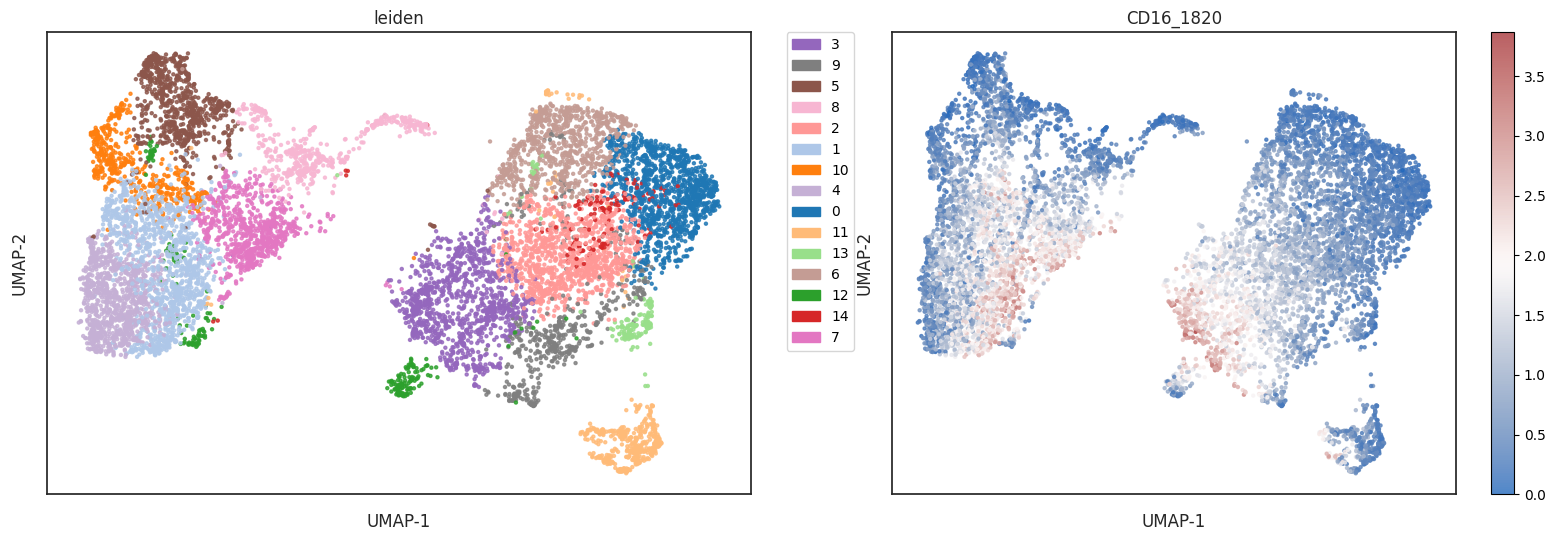

In [5]:
# Plot results to verify clustering and umap execution
sm.pl.umap(adata, color=["leiden","CD16_1820"], figsize=(20,6))

In [6]:
# NEW: Neighborhoud analysis (to be implemented in Tercen)
# The algorithm uses cluster phenotype results ("leiden") and spatial coordinates ("X_centroid" , "Y_centroid")

# Count the number of cell phenotypes (leiden) within 80 pixel-radius regions in the imaging
adata = sm.tl.spatial_count(adata, phenotype="leiden", method="radius", radius=80, label="spatial_count")

# Cluster each 80 pixels radius region using kmeans to identify neighbourhood regions
adata = sm.tl.spatial_cluster(adata, df_name="spatial_count", method="kmeans", k=8, label="neigh_kmeans")

Identifying neighbours within 80 pixels of every cell
Identifying neighbours within 80 pixels of every cell
Identifying neighbours within 80 pixels of every cell
Kmeans clustering


In [7]:
# Export .csv for each patient
def outputcsv (dataframe, patient):
    dataframe[["UMAP_1","UMAP_2"]] = adata.obsm["umap"][adata.obs["imageid"] == patient]
    dataframe[["leiden","neigh_kmeans"]] = adata.obs[["leiden","neigh_kmeans"]][adata.obs["imageid"] == patient].to_numpy()
    dataframe.to_csv(f"{patient}_after.csv", index=False)

outputcsv(patient1, "Patient1")
outputcsv(patient2, "Patient2")
outputcsv(patient3, "Patient3")

### Examples of Overlay Dot Plots

Below are examples of overlay dot plots that users can generate in Tercen after performing neighborhood analysis.

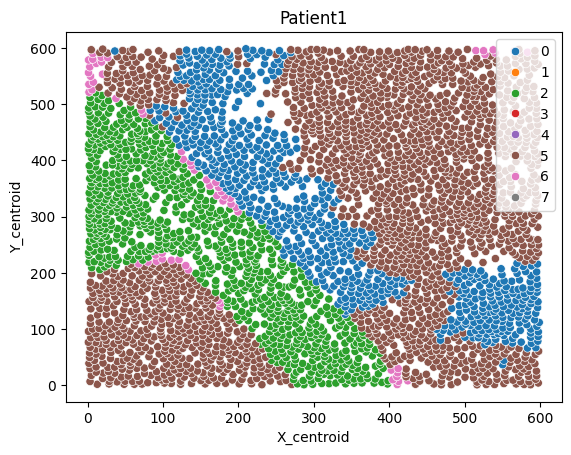

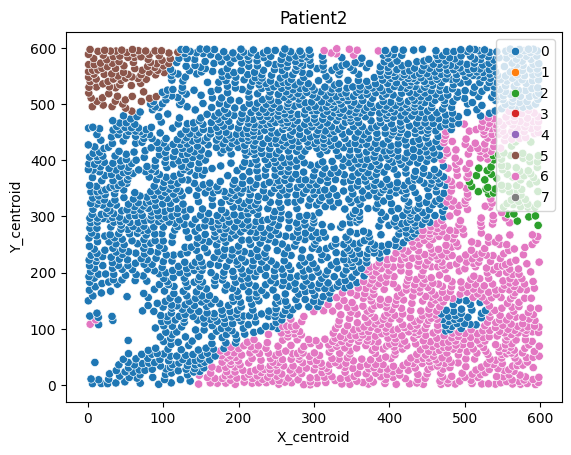

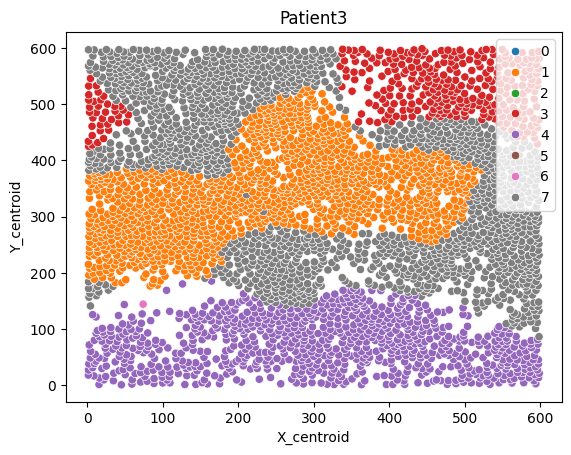

In [8]:
# Dots represents cells in the tissue, color-coded by the neighbourhood analysis
for patient in adata.obs["imageid"].unique():
    filt = adata.obs["imageid"]==patient
    sns.scatterplot(adata[filt].obs, x= "X_centroid",y="Y_centroid", hue="neigh_kmeans", hue_order=["0","1","2","3","4","5","6","7"])
    plt.title(patient)
    plt.legend(loc="upper right")
    plt.show()

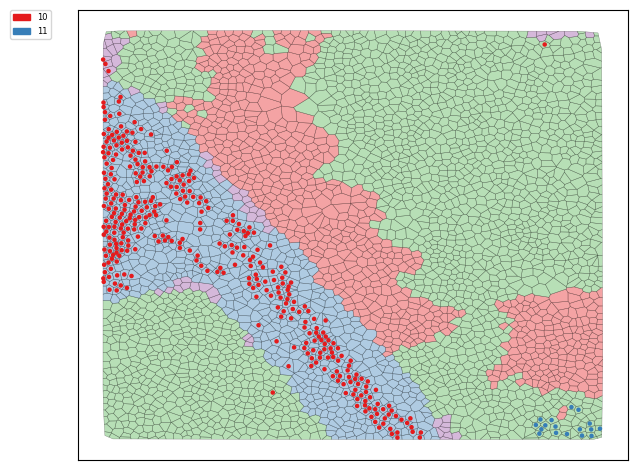

In [9]:
# Alternatively, TERCEN can also implement the voronoi graph below, which provides a more informative spatial representation of cells compared to simple dot plots.
sm.pl.voronoi(adata, color_by='neigh_kmeans',
              subset="Patient1", 
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0.3, 
                 voronoi_alpha = 0.4, 
                 size_max=3000,
                 overlay_points="leiden",
                 overlay_point_size=20,
                 overlay_points_categories=["11","10"], 
                 plot_legend=True, 
                 legend_size=6,
                 flip_y=False)